# Exportar en COCO y descargar por SDK

In [1]:
import os
import requests
from decouple import config
from label_studio_sdk import Client

LABEL_STUDIO_URL = config("LABEL_STUDIO_URL") 
API_KEY = config("LABEL_STUDIO_API_KEY") 

In [2]:
# Inicializar el cliente
ls = Client(url=LABEL_STUDIO_URL, api_key=API_KEY)

# Obtener todos los proyectos
projects = ls.get_projects()

# Imprimir detalles de cada proyecto
print(f"Proyectos encontrados: {len(projects)}")
for project in projects:
    print(f"ID: {project.id} - Nombre: {project.get_params()['title']}")

Proyectos encontrados: 6
ID: 8 - Nombre: TesisStraight
ID: 6 - Nombre: TesisAsistencia
ID: 5 - Nombre: TesisVotacion
ID: 4 - Nombre: TCG-Straight
ID: 3 - Nombre: TCG-cuadros
ID: 2 - Nombre: TCG-Segmentation


In [8]:
# Configuración
PROJECT_ID = 8

# Crear carpeta de salida
output_dir = '../../data/c_label_studio_straight/download/images'
os.makedirs(output_dir, exist_ok=True)

# Conectar con Label Studio
ls = Client(url=LABEL_STUDIO_URL, api_key=API_KEY)
project = ls.get_project(PROJECT_ID)
tasks = project.get_tasks()
print(f"Total imágenes encontradas: {len(tasks)}")

Total imágenes encontradas: 124


In [7]:
# Descargar imágenes con contador
total = len(tasks)
print(f"Descargando {total} imágenes...")

for i, task in enumerate(tasks, start=1):
    image_path = task['data'].get('image')
    if image_path:
        full_url = f"{LABEL_STUDIO_URL}{image_path}"
        file_name = os.path.basename(image_path)
        output_path = os.path.join(output_dir, file_name)

        response = requests.get(full_url, headers={'Authorization': f'Token {API_KEY}'}, stream=True)
        if response.status_code == 200:
            with open(output_path, 'wb') as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
            print(f"[{i}/{total}] ✅ Descargado: {file_name}")
        else:
            print(f"[{i}/{total}] ❌ Error al descargar {file_name}: {response.status_code}")
    else:
        print(f"[{i}/{total}] ⚠️ Tarea sin imagen asociada")


Descargando 124 imágenes...
[1/124] ✅ Descargado: e3d202f0-000_12-jun-15-ASISTENC-SIN-QUORUM_page_2.png
[2/124] ✅ Descargado: 504c16e2-000_15-12-15-oficial_page_9.png
[3/124] ✅ Descargado: c4a84b1a-000_Asis-vot-07-07-2011-CF_page_3.png
[4/124] ✅ Descargado: d410f696-000_Asis-vot-16-06-2011-CF_page_42.png
[5/124] ✅ Descargado: 5c81ab2c-000_Asis-vot-16-12-2010-CF_page_4.png
[6/124] ✅ Descargado: 9c1faa20-000_Asis-vot-OFICIAL-23-06-2010-CF_page_4.png
[7/124] ✅ Descargado: 348c6146-000_AS-VOT-16-06-16-OFICIAL_page_12.png
[8/124] ✅ Descargado: af7cb9cc-001_0-as-vot-28-06-17-OFICIAL_page_1.png
[9/124] ✅ Descargado: bacc5476-001_Asis_vot_OFICIAL_2-02-22_page_41.png
[10/124] ✅ Descargado: 9e5da8f5-001_Asis_vot_OFICIAL_22-06-2023_page_121.png
[11/124] ✅ Descargado: fa56606c-001_Asistencias-y-Votaciones-7-jun-2012_page_10.png
[12/124] ✅ Descargado: 5ea97747-001_Asis-vot-15-06-2011-CF_page_23.png
[13/124] ✅ Descargado: c2509286-001_Asis-vot-OFICIAL-15-07-21_page_5.png
[14/124] ✅ Descargado: dd60d

# Generar Labels a partir de COCO

In [10]:
import json
import os

# Ruta del archivo COCO exportado desde Label Studio
coco_json_path = '../../data/c_label_studio_straight/download/result.json'

# Directorio donde guardaremos las etiquetas en formato YOLO
yolo_labels_dir = "../../data/c_label_studio_straight/download/labels"

# Asegurar que la carpeta de etiquetas exista
os.makedirs(yolo_labels_dir, exist_ok=True)

# Cargar los datos en formato COCO
with open(coco_json_path, 'r') as f:
    coco_data = json.load(f)

# Mapear IDs de clase a nombres
category_map = {cat["id"]: cat["name"] for cat in coco_data["categories"]}

# Crear diccionario para almacenar anotaciones por imagen
annotations_by_image = {}

for annotation in coco_data["annotations"]:
    image_id = annotation["image_id"]
    category_id = annotation["category_id"]
    segmentation = annotation["segmentation"]

    # Obtener dimensiones de la imagen
    img_info = next((img for img in coco_data["images"] if img["id"] == image_id), None)
    if not img_info:
        continue

    img_width, img_height = img_info["width"], img_info["height"]

    # Asegurar que la segmentación sea una lista de listas (COCO permite múltiples segmentos por anotación)
    if isinstance(segmentation, list) and len(segmentation) > 0:
        # Tomamos solo el primer polígono en caso de varios
        segmentation = segmentation[0]

        # Normalizar coordenadas de segmentación (x / width, y / height)
        normalized_segmentation = [str(round(segmentation[i] / img_width, 6)) if i % 2 == 0 
                                   else str(round(segmentation[i] / img_height, 6)) 
                                   for i in range(len(segmentation))]

        # Reestructurar anotaciones en formato YOLO-seg (clase seguido de coordenadas normalizadas)
        annotation_str = f"{category_id} " + " ".join(normalized_segmentation)

        # Guardar la anotación en la imagen correspondiente
        if image_id not in annotations_by_image:
            annotations_by_image[image_id] = []
        annotations_by_image[image_id].append(annotation_str)

# Guardar anotaciones en formato YOLO
for image in coco_data["images"]:
    image_id = image["id"]
    image_filename = os.path.splitext(os.path.basename(image["file_name"]))[0]  # 💡 Corregido aquí

    # Ruta del archivo de anotación en YOLO format
    label_file_path = os.path.join(yolo_labels_dir, f"{image_filename}.txt")

    if image_id in annotations_by_image:
        with open(label_file_path, "w") as f:
            f.write("\n".join(annotations_by_image[image_id]))

print(f"✅ Conversión completa. Etiquetas guardadas en: {yolo_labels_dir}")


✅ Conversión completa. Etiquetas guardadas en: ../../data/c_label_studio_straight/download/labels


# Probar máscaras

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random

def visualizar_mascara_aleatoria(images_dir):
    """
    Selecciona aleatoriamente una imagen de la carpeta dada y visualiza su máscara
    basada en las etiquetas YOLO.
    
    Parámetros:
    - images_dir: Ruta de la carpeta que contiene las imágenes.
    """
    # Obtener todas las imágenes válidas en la carpeta
    extensiones_validas = (".png", ".jpg", ".jpeg")
    imagenes = [f for f in os.listdir(images_dir) if f.lower().endswith(extensiones_validas)]

    if not imagenes:
        print("No se encontraron imágenes en la carpeta.")
        return

    # Seleccionar una imagen aleatoriamente
    imagen_seleccionada = random.choice(imagenes)
    image_path = os.path.join(images_dir, imagen_seleccionada)

    # Generar la ruta del archivo de etiquetas
    label_path = image_path.replace("/images/", "/labels/").replace(".png", ".txt").replace(".jpg", ".txt")

    # Verificar si el archivo de etiquetas existe
    if not os.path.exists(label_path):
        print(f"Etiqueta no encontrada para: {image_path}")
        return

    # Leer la imagen
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Crear una máscara vacía
    mask = np.zeros_like(image, dtype=np.uint8)

    # Leer el archivo de etiquetas
    with open(label_path, "r") as f:
        for line in f:
            label_data = line.strip().split()
            coords = np.array(label_data[1:], dtype=np.float32).reshape(-1, 2)  # Ignorar el primer valor

            # Convertir coordenadas normalizadas a valores reales
            h, w, _ = image.shape
            coords[:, 0] *= w  # Escalar X
            coords[:, 1] *= h  # Escalar Y

            # Dibujar la máscara en la imagen
            pts = coords.astype(np.int32).reshape((-1, 1, 2))
            cv2.fillPoly(mask, [pts], (0, 255, 0))  # Máscara en rojo

    # Superponer la máscara sobre la imagen original
    overlay = cv2.addWeighted(image, 0.7, mask, 0.3, 0)

    # Mostrar la imagen con la máscara
    plt.figure(figsize=(10, 10))
    plt.title(f"Imagen: {imagen_seleccionada}")
    plt.imshow(overlay)
    plt.axis("off")
    plt.show()

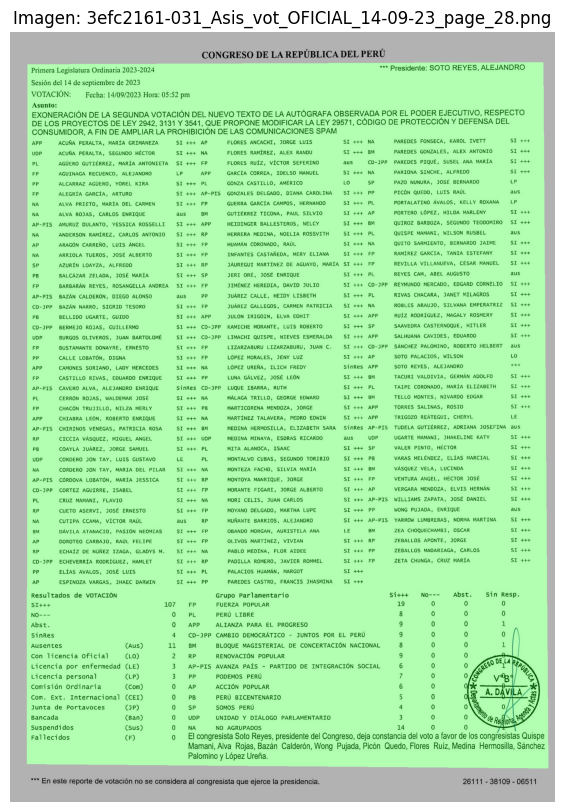

In [15]:
visualizar_mascara_aleatoria('../../data/c_label_studio_straight/download/images')